In [1]:
## Etapa 1: Instalação de dependências e importações

# Instalação do kagglehub e importações principais para o pipeline.

!pip install kagglehub

import kagglehub
import os
import shutil
import tensorflow as tf
import numpy as np
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
## Etapa 2: Download e organização do dataset

# Baixa os datasets do Kaggle e organiza as imagens em pastas por classe, limitando a 200 imagens por classe.

datasets = {
    "relogio": "ahedjneed/fancy-watche-images",
    "camiseta": "sunnykusawa/tshirts",
    "bicicleta": "dataclusterlabs/bicycle-image-dataset-vehicle-dataset",
    "sapato": "noobyogi0100/shoe-dataset"
}

base_dir = "/content/data"
os.makedirs(base_dir, exist_ok=True)

for classe, dataset in datasets.items():
    path = kagglehub.dataset_download(dataset)
    print(f"Dataset '{classe}' baixado em: {path}")

    classe_dir = os.path.join(base_dir, classe)
    os.makedirs(classe_dir, exist_ok=True)

    count = 0
    for root, _, files in os.walk(path):
        if count >= 200:
            break
        for file in files:
            if count >= 200:
                break
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                origem = os.path.join(root, file)
                destino = os.path.join(classe_dir, file)
                if os.path.exists(destino):
                    base, ext = os.path.splitext(file)
                    destino = os.path.join(classe_dir, f"{base}_{count}{ext}")
                shutil.copy(origem, destino)
                count += 1
    print(f"{classe}: {count} imagens copiadas")


100%|██████████| 63.4M/63.4M [00:04<00:00, 15.9MB/s]

Extracting files...


Dataset 'relogio' baixado em: /root/.cache/kagglehub/datasets/ahedjneed/fancy-watche-images/versions/4
relogio: 200 imagens copiadas


100%|██████████| 358M/358M [00:14<00:00, 26.2MB/s]

Extracting files...


Dataset 'camiseta' baixado em: /root/.cache/kagglehub/datasets/sunnykusawa/tshirts/versions/2
camiseta: 200 imagens copiadas


100%|██████████| 723M/723M [00:26<00:00, 28.6MB/s]

Extracting files...


Dataset 'bicicleta' baixado em: /root/.cache/kagglehub/datasets/dataclusterlabs/bicycle-image-dataset-vehicle-dataset/versions/2
bicicleta: 200 imagens copiadas


100%|██████████| 324M/324M [00:13<00:00, 25.4MB/s]

Extracting files...


Dataset 'sapato' baixado em: /root/.cache/kagglehub/datasets/noobyogi0100/shoe-dataset/versions/1
sapato: 200 imagens copiadas


In [17]:
## Etapa 3: Divisão do dataset com ImageDataGenerator

# Cria os datasets de treino e validação com aumento de dados.

img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
)


train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 640 images belonging to 4 classes.
Found 160 images belonging to 4 classes.


In [18]:
## 3.1 Checando os dados para garantir que as classes estão bem distribuídas:

print(train_gen.class_indices)
print(train_gen.classes[:20])
print(np.bincount(train_gen.classes))


{'bicicleta': 0, 'camiseta': 1, 'relogio': 2, 'sapato': 3}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[160 160 160 160]


In [20]:
## Etapa 4: Criação do modelo com Transfer Learning

# Utiliza VGG16 pré-treinado com camadas personalizadas.

# Carregar modelo pré-treinado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar todas as camadas, exceto as últimas camadas para fine-tuning
for layer in base_model.layers[:-2]:
    layer.trainable = False


In [21]:
## Etapa 4.1: Camadas personalizadas

# Adicionar camadas customizadas
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.05)(x)  # Dropout para evitar overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

x = Dense(train_gen.num_classes, activation='softmax')(x)  # Saída com 4 classes

In [22]:
## Etapa 4.2: Compilando o modelo final

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar o modelo com uma Learning Rate menor
#optimizer = Adam(learning_rate=0.00005)
optimizer = 'adam'
# Compilar o modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para evitar overfitting e ajustar a taxa de aprendizado
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.65, patience=3, min_lr=5e-4)


In [23]:
## Etapa 5: Treinamento do modelo

# Treinar o modelo com os geradores
history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 472s 12s/step - accuracy: 0.4793 - loss: 1.1530 - val_accuracy: 0.8625 - val_loss: 0.3251 - learning_rate: 0.0010
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 464s 12s/step - accuracy: 0.8813 - loss: 0.3199 - val_accuracy: 0.8500 - val_loss: 0.7115 - learning_rate: 0.0010
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 466s 12s/step - accuracy: 0.9323 - loss: 0.2207 - val_accuracy: 0.9062 - val_loss: 0.5123 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 466s 12s/step - accuracy: 0.9628 - loss: 0.1560 - val_accuracy: 0.9250 - val_loss: 0.3067 - learning_rate: 0.0010
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 517s 13s/step - accuracy: 0.9628 - loss: 0.1684 - val_accuracy: 0.8938 - val_loss: 0.2830 - learning_rate: 0.0010
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 465s 12s/step - accuracy: 0.9345 - loss: 0.1885 - val_accuracy: 0.9312 - val_loss: 0.4069 - learning_rate: 0.0010
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 502s 12s/step - accuracy: 0.9745 - loss: 0.0692 - 

In [24]:
## Etapa 5.1: Salvando o modelo treinado (pesos)

# Salvar os pesos do modelo
model.save("/content/model_recommendation_4classes.keras")

# Representação da estrutura e dos parâmetros aprendidos que serão usados ​​para predição.
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 38,883,678 (148.33 MB)

 Trainable params: 8,842,932 (33.73 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

 Optimizer params: 17,685,866 (67.47 MB)

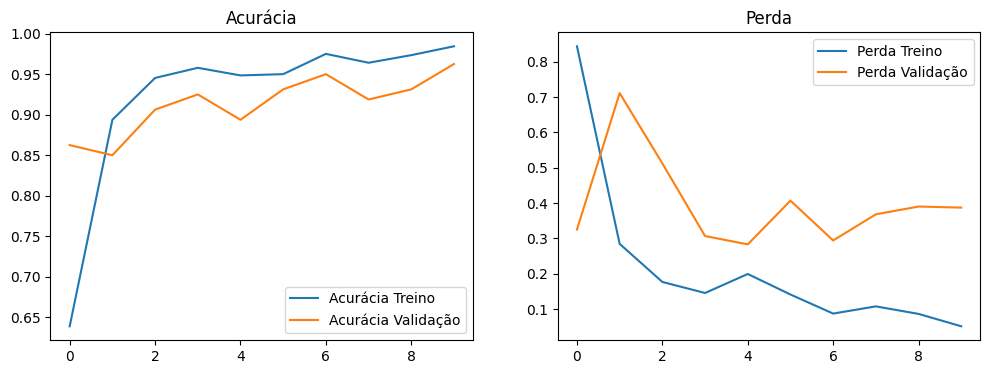

In [25]:
## Etapa 5.2: Análise gráfica da evolução do treinamento

# Plotando os resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

model_history = model.history

ax1.plot(model_history.history['accuracy'], label='Acurácia Treino')
ax1.plot(model_history.history['val_accuracy'], label='Acurácia Validação')
ax1.set_title('Acurácia')
ax1.legend()

ax2.plot(model_history.history['loss'], label='Perda Treino')
ax2.plot(model_history.history['val_loss'], label='Perda Validação')
ax2.set_title('Perda')
ax2.legend()

plt.show()

In [ ]:
## Etapa 6: Fine-tuning (opcional)

# Descongela parte do modelo base e ajusta com taxa de aprendizado menor.

base_model.trainable = True
for layer in base_model.layers[:-2]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(train_gen, validation_data=val_gen, epochs=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


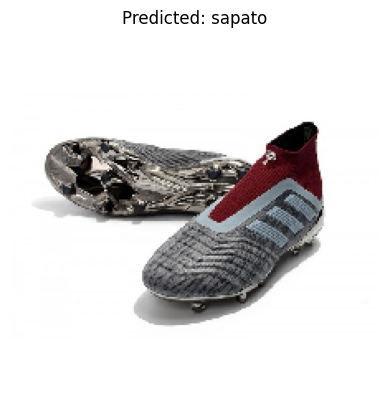

In [27]:
## Etapa 8: Teste com imagem individual (classificação)

model = load_model('/content/model_recommendation_4classes.keras')
class_names = ['bicicleta', 'camiseta', 'relogio', 'sapato']

img_path = '/content/data/sapato/image251.jpeg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {predicted_class}')
plt.show()

In [28]:
## Etapa 9: Extração de Embeddings com o Modelo Treinado

# Usar o modelo treinado (com classificação nas 4 classes) e remover a última camada (classificadora) para extrair apenas os vetores de características (embeddings).

# Carrega o modelo treinado
full_model = load_model('/content/model_recommendation_4classes.keras')

# Extrai o penúltimo layer (camada de embeddings)
embedding_model = Model(inputs=full_model.input, outputs=full_model.layers[-2].output)
embedding_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,197,744 (80.86 MB)

 Trainable params: 8,842,864 (33.73 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [29]:
## Etapa 10: Geração de Embeddings para o Banco de Dados

# Percorre todas as imagens organizadas por classe e salva os embeddings + rótulo + caminho.

embeddings = []
paths = []
labels = []

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    for filename in tqdm(os.listdir(class_path), desc=f"Processando {class_name}"):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_path, filename)
            img = load_img(img_path, target_size=(224, 224))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0) / 255.0
            feat = embedding_model.predict(x, verbose=0)
            embeddings.append(feat[0])
            paths.append(img_path)
            labels.append(class_name)

# Cria DataFrame
df_embed = pd.DataFrame(embeddings)
df_embed['path'] = paths
df_embed['label'] = labels

# Salva os embeddings
df_embed.to_pickle('/content/image_embeddings_from_trained_model.pkl')


Processando bicicleta: 100%|██████████| 200/200 [02:47<00:00,  1.19it/s]


In [30]:
## Etapa 11: Sistema de Recomendação por Similaridade Visual

### 11.1 Carregar os embeddings

df_embed = pd.read_pickle('/content/image_embeddings_from_trained_model.pkl')

image_vectors = df_embed.drop(['path', 'label'], axis=1).values
image_paths = df_embed['path'].values
image_labels = df_embed['label'].values

In [31]:
### 11.2 Função de processamento da imagem de consulta

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0
    return x

In [35]:
### 11.3 Extração do vetor da imagem de entrada

query_img_path = '/content/data/relogio/017_b3707f93.jpg'  # Substituir pelo caminho desejado
query_img = preprocess_image(query_img_path)
query_vector = embedding_model.predict(query_img)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


In [36]:
### 11.4 Cálculo da similaridade com o banco (cosine)

# Calcula a similaridade entre o vetor da consulta e todos os outros
sims = cosine_similarity([query_vector], image_vectors)[0]

# Ordena do mais semelhante ao menos semelhante
top_n = 5
top_indices = sims.argsort()[-top_n:][::-1]


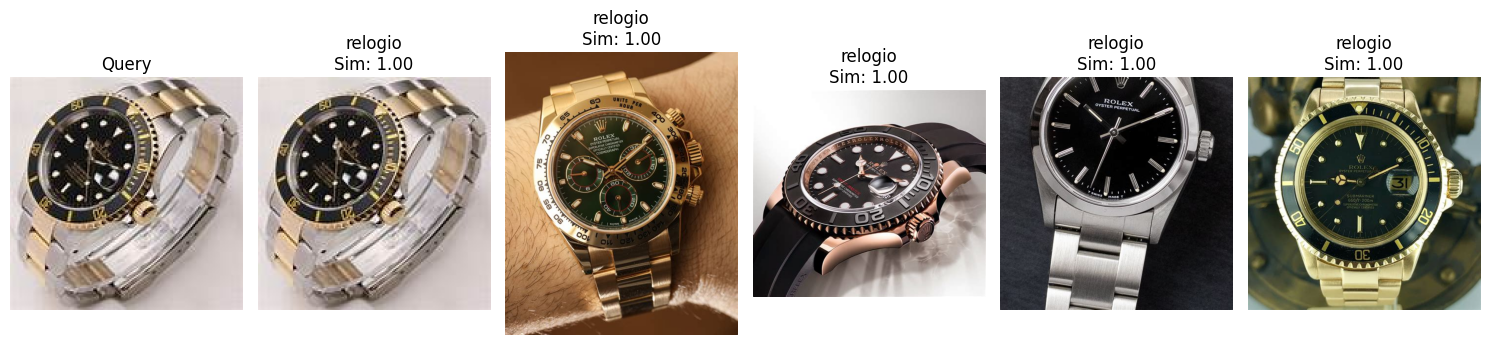

In [37]:
### 11.5 Visualização das recomendações

def show_similar_images(indices, query_path, sims, paths, labels):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query")
    plt.axis('off')

    for i, idx in enumerate(indices):
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(Image.open(paths[idx]))
        plt.title(f"{labels[idx]}\nSim: {sims[idx]:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_similar_images(top_indices, query_img_path, sims, image_paths, image_labels)

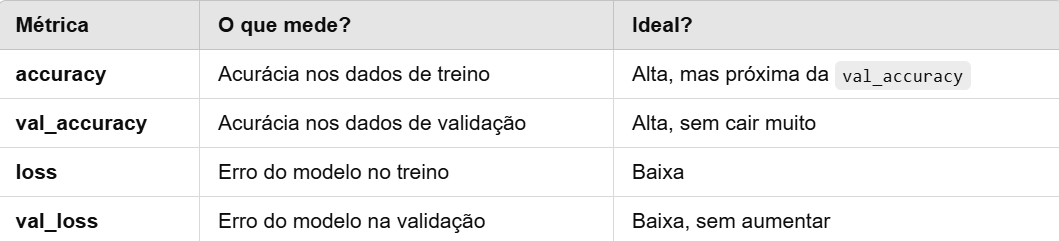



***1️⃣ Se a acurácia da validação começar a cair:***

* Se a acurácia de treino for alta (ex: 99%), mas a de validação for muito menor e começar a cair (ex: 85% → 75%), o modelo está claramente overfitado e pode falhar em novos dados.

***2️⃣ Se a perda da validação (val_loss) aumentar enquanto a do treino cai:***

* Se loss no treino continuar diminuindo (0.1 → 0.05 → 0.02), mas val_loss aumentar (0.2 → 0.4 → 0.6), o modelo está memorizando os dados de treino e não conseguirá prever bem em novos dados.


*   Se loss e val_loss descem juntos → O modelo está aprendendo bem.
*   Se loss desce, mas val_loss sobe → O modelo está overfitting.
*   Se accuracy e val_accuracy sobem juntas → O modelo está generalizando bem.


***Se precisar de ajustes no treinamento:***


*   Aumentar dropout para reduzir overfitting.
*   Aplicar data augmentation para melhorar a generalização.
*   Treinar por mais épocas se o modelo ainda não convergiu.

***🔧 Ajustes Implementados***


*   Data Augmentation → Aumenta a diversidade do dataset artificialmente.
*   Dropout (Regularização) → Evita que o modelo memorize padrões específicos.
*   L2 Regularization → Penaliza pesos muito grandes para melhorar a generalização.
*   Early Stopping → Para o treinamento quando o modelo para de melhorar.
*   Learning Rate Scheduling → Ajusta a taxa de aprendizado ao longo do tempo.
